# Lab Assignment 2

**Computer Vision** - Term 5, 2023

Instructor: Dr. Saumya Jetley <br>
TA: Ribhu Lahiri, Raghav Awasty

For reference: 
* Define a filter (matrix of values) that can be convolved with the input image to extract different kinds of frequency information from the image.
* Implement the Sobel, Canny and Laplace edge detectors.
* Modify the filter values to create new filters and observe the output when convolved with the input image.


In [2]:
# Imports 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Reading in a sample image
import gdown

id = "1oIK5OKyx-J82R0LR2g3-8w7YAUB-L6ra"
gdown.download(id=id, output='cube.jpeg', quiet=True)

id = "1oO2uY_bZhD9O9F45F8jZ0HBYmv9vIUo9"
gdown.download(id=id, output='einstein.jpeg', quiet=True)

im = cv2.imread("./cube.jpeg", 0)

**Implement the convolve function** *(1 point)*

Use the helper method `window` to create a function that uses the sliding window to convolve over a given image.

In [4]:
# Task: 

def window(receptive_field, filter):
    ''' 
    Convolves a filter over the receptive field from the image

    Parameters
    ----------
    receptive_field: np.ndarray
        The portion of the image the convolution is being done over

    filter: np.ndarray
        The defined filter

    Returns
    -------
    np.ndarray
        The convolved receptive field output
    '''
    return np.sum(filter * receptive_field)
    
def convolve(image, kernel):
    ''' 
    Convolves the filter over the image (sliding window)

    Parameters
    ----------
    image: np.ndarray
        The image as a 2-dimensional matrix

    kernel: np.ndarray
        The defined filter

    Returns
    -------
    output_image: np.ndarray
        The image after convolving the filter over it
    '''
    h, w = image.shape
    kh, kw = kernel.shape
    oh = int((h - kh) + 1)
    ow = int((w - kw) + 1)
    out = np.zeros((oh, ow))
    for i in range(oh):
        for j in range(ow):
            rf = image[i:i+kh, j:j+kw]
            out[i, j] = window(rf, kernel)

    return out

Sample sharpen filter to check functionality

In [5]:
image_array = np.asarray(im)

# Sharpen
filter = np.array(([0, -1, 0], 
                   [-1, 7, -1], 
                   [0, -1, 0]))

In [6]:
filtered_im = convolve(image_array, filter)

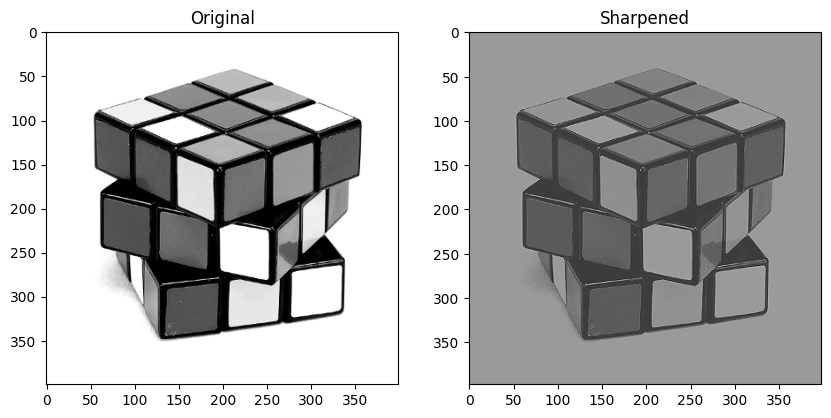

In [7]:
fsize = (10, 6)
plt.figure(figsize = fsize)
plt.subplot(121),plt.imshow(im, 'gray'), plt.title('Original')
plt.subplot(122),plt.imshow(filtered_im, 'gray'), plt.title('Sharpened')
plt.show()

## Sobel filters to check functionality

- Converting the image into grayscale
- Convolving the gray image with Sobel-x filter
- Convolving the gray image with Sobel-y filter
- Calculating the gradient magnitude and direction

In [8]:
# Sobel filters
sobel_x = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]])

# gaussian_1d = np.array([1, 2, 1],np.float32)
# x_derivative = np.array([-1, 0, 1],np.float32)
# s_x = np.outer(gaussian_1d, x_derivative)  
# s_y = np.outer(x_derivative, gaussian_1d)

filtered_v = convolve(image_array, sobel_x)
filtered_h = convolve(image_array, sobel_y)

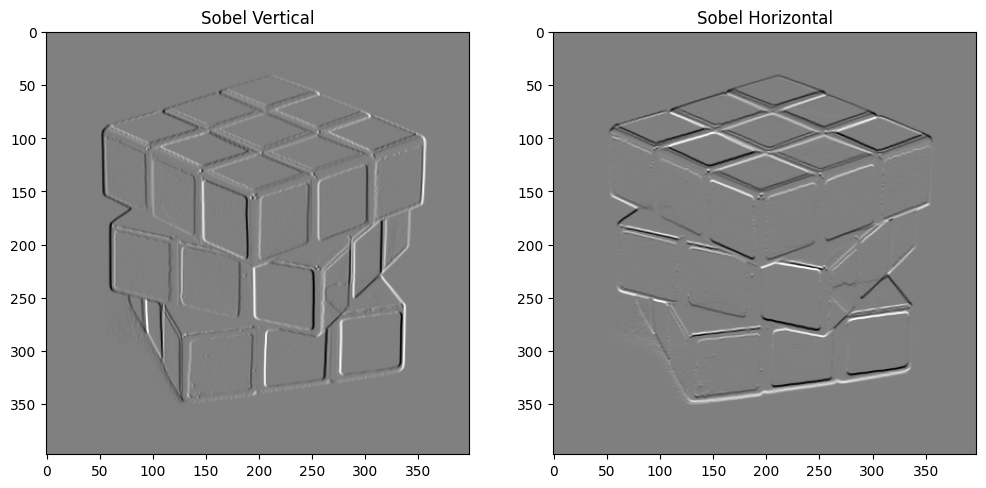

In [9]:
fsize = (12,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(filtered_v, 'gray'), plt.title('Sobel Vertical')
plt.subplot(122), plt.imshow(filtered_h, 'gray'), plt.title('Sobel Horizontal')
plt.show()

In [10]:
# Combining them to get the gradients magnitude (scales intensities b/w 0 and max)
sobel_manual = np.sqrt(filtered_h**2 + filtered_v**2)

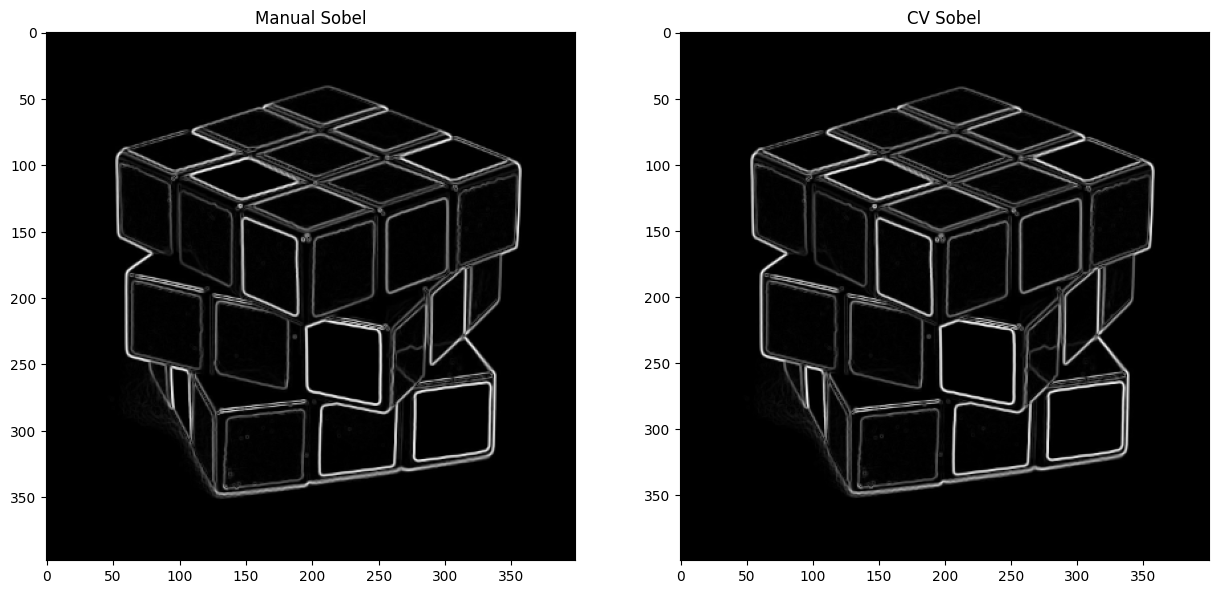

In [11]:
# Using the CV2 module
sobel_x_cv = cv2.Sobel(image_array,cv2.CV_64F, 1, 0, ksize=3)
sobel_y_cv = cv2.Sobel(image_array,cv2.CV_64F, 0, 1, ksize=3)
sobel_cv = np.hypot(np.absolute(sobel_x_cv), np.absolute(sobel_y_cv))

fsize = (15, 8)
plt.figure(figsize=fsize)
plt.subplot(121), plt.imshow(sobel_manual, 'gray'), plt.title('Manual Sobel')
plt.subplot(122), plt.imshow(sobel_cv, 'gray'), plt.title('CV Sobel')
plt.show()

## Canny edge-detection step:

### 1. Apply Gaussian Kernel to **smooth edges**

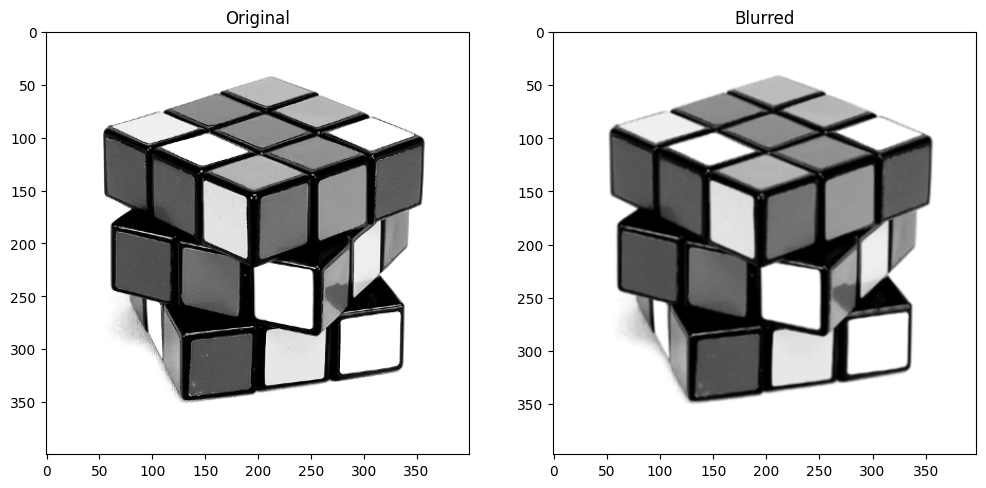

In [12]:
# Applying gaussian blurring
gaussian = np.array([[1, 2, 1],
                     [2, 4, 2],
                     [1, 2, 1]]) / 16

blurred = convolve(image_array, gaussian)

fsize = (12,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(im, 'gray'), plt.title('Original')
plt.subplot(122), plt.imshow(blurred, 'gray'), plt.title('Blurred')
plt.show()

### 2. Apply Sobel filter to **find gradients**
    
- Gradient Magnitude: 
$$Gm = \sqrt{x^2 + y^2}$$
    
- Gradient Direction
$$Gd = arctan(y/x)$$

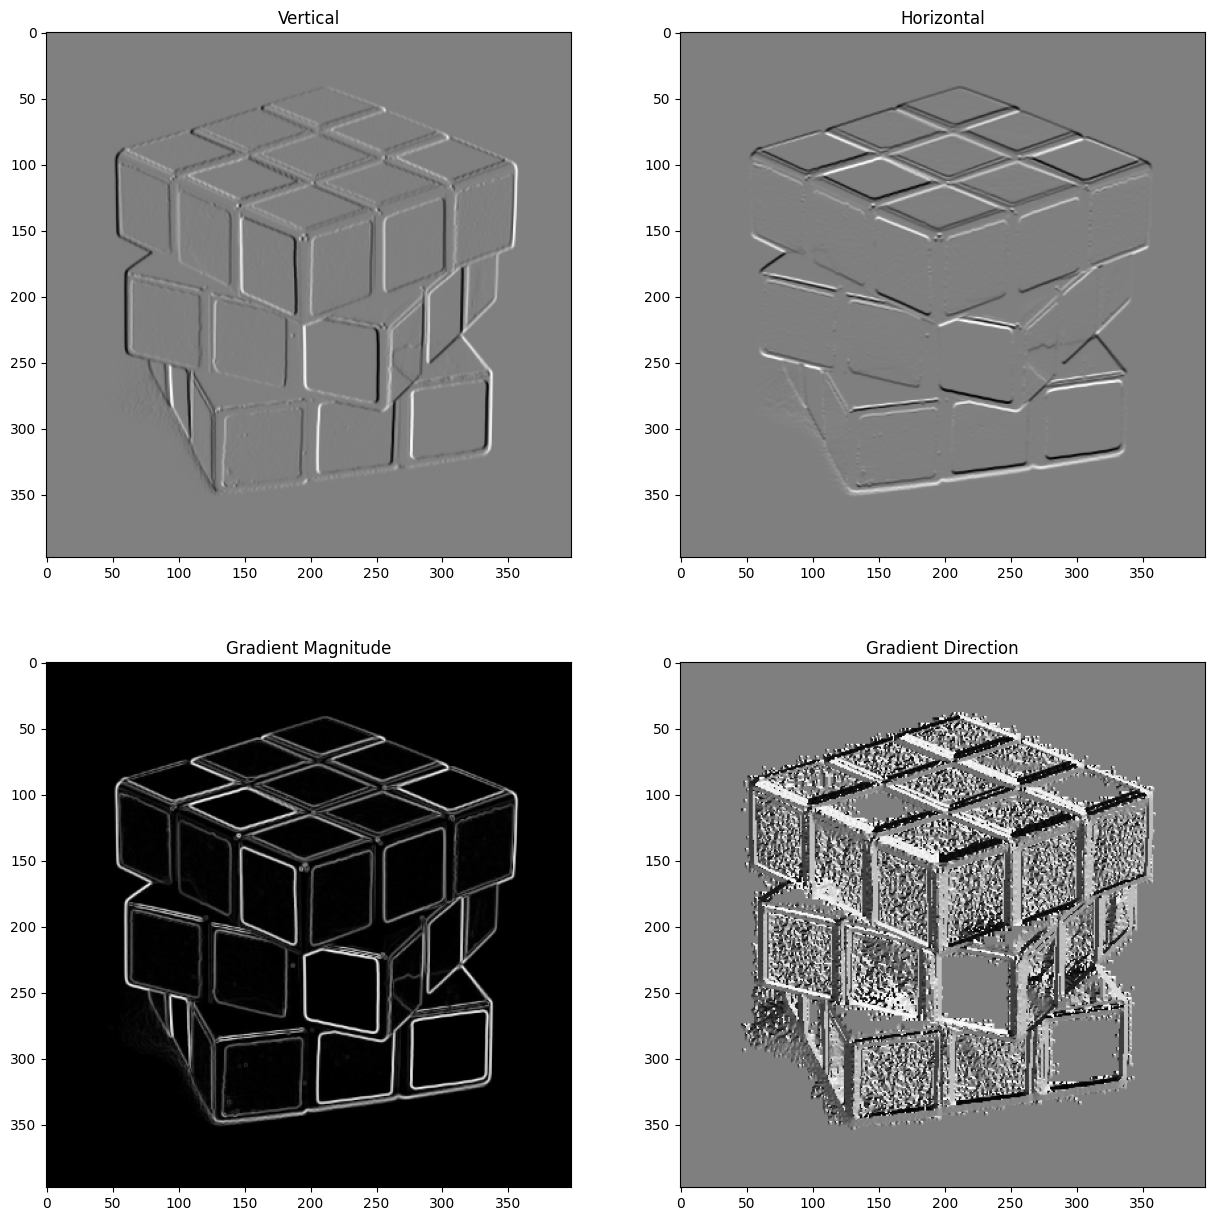

In [13]:
# Applying the sobel filter to detect edges
filtered_v = convolve(im, sobel_x)
filtered_h = convolve(im, sobel_y)

# Finding the gradient magnitude and direction to be passed to NMS
Gm = (filtered_v**2 + filtered_h**2)**0.5
Gd = np.rad2deg(np.arctan2(filtered_v, filtered_h))

fsize = (15, 15)
plt.figure(figsize = fsize)
plt.subplot(221), plt.imshow(filtered_v, 'gray'), plt.title('Vertical')
plt.subplot(222), plt.imshow(filtered_h, 'gray'), plt.title('Horizontal')
plt.subplot(223), plt.imshow(Gm, 'gray'), plt.title('Gradient Magnitude')
plt.subplot(224), plt.imshow(Gd, 'gray'), plt.title('Gradient Direction')
plt.show()

### 3. Non-maximum suppression for **edge thinning (preserves the sharpest gradients and discards the others)** *(1 point)*

- Check every pixel on the Gradient magnitude image and choose 2 neighbor of the pixel according to Gradient Direction. If center pixel is larger than the both neighbors then keep it, otherwise set the pixel to 0

```
for each pixel:
    pick the neighbouring pixels based on gradient direction
    if pixel value > neighbouring pixels:
        pixel value == pixel value
    else:
        pixel value == 0
```

In [14]:

def f_NMS(Gm, Gd):
    ''' 
    Applies non-maximal suppression to the gradient magnitude using the gradient direction

    Parameters
    ----------
    Gm: np.ndarray
        The gradient magnitude

    Gd: np.ndarray
        The gradient directions

    Returns
    -------
    np.ndarray
        The image with supressed edges
    '''

    r, c = Gm.shape
    out = np.zeros((r, c))
    step = 45
    angles = np.arange(-step, 180+step, step)

  
    for i in range(1, r-1):
        for j in range(1, c-1):
            d = Gd[i, j]
            if d >= angles[0] and d < angles[1]:
                n = [Gm[i, j-1], Gm[i, j+1]]
            elif d >= angles[1] and d < angles[2]:
                n = [Gm[i-1, j+1], Gm[i+1, j-1]]
            elif d >= angles[2] and d < angles[3]:
                n = [Gm[i-1, j], Gm[i+1, j]]
            else:
                n = [Gm[i-1, j-1], Gm[i+1, j+1]]

            if Gm[i, j] >= max(n):
                out[i, j] = Gm[i, j]

    return out


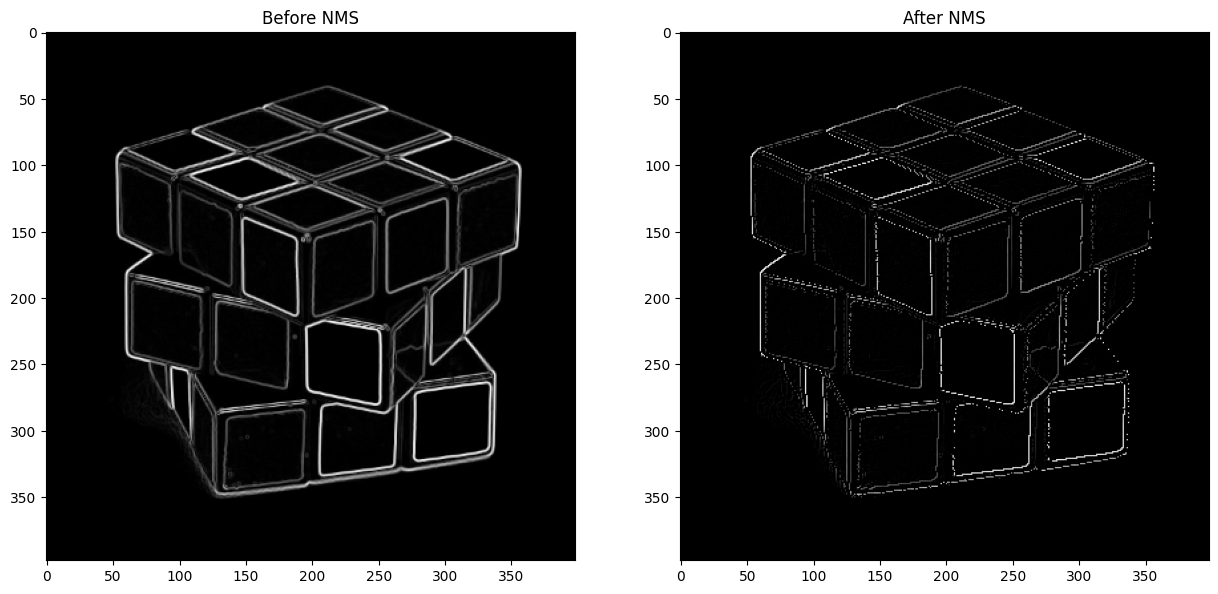

In [15]:
G_NMS = f_NMS(Gm, Gd)
fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(Gm, 'gray'), plt.title('Before NMS')
plt.subplot(122), plt.imshow(G_NMS, 'gray'), plt.title('After NMS')
plt.show()

### 4. Double thresholding to **preserve strong/relevant edges** *(1 point)*

```
For each pixel:
    if pixel value < lower threshold:
        pixel value == 0
    elif pixel value > higher threshold:
        pixel value == strong (255)
    else:
        pixel value == weak
        hysteresis pass
```

In [16]:
import numpy as np

def threshold(img, low_thresh_ratio, high_thresh_ratio):
    ''' 
    Filter the strong and relevant edges from the gradient magnitude 
    and removes weak edges based on a high and low threshold value

    Parameters
    ----------
    img: np.ndarray
        The gradient magnitude

    low_thresh_ratio: float
        The fraction of either the max/mean intensity to create the low threshold

    high_thresh_ratio: float
        The fraction of either the max/mean intensity to create the high threshold

    Returns
    -------
    res: np.ndarray
        The image with the filtered pixel intensities

    weak: int
        The value set for the weak pixels to be passed to the hysterisis mechanism

    strong: int
        The value set for the strong pixels to be passed to the hysterisis mechanism
    '''

    high_thresh = img.max() * high_thresh_ratio
    low_thresh = high_thresh * low_thresh_ratio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= high_thresh)
    zeros_i, zeros_j = np.where(img < low_thresh)
    
    weak_i, weak_j = np.where((img <= high_thresh) & (img >= low_thresh))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


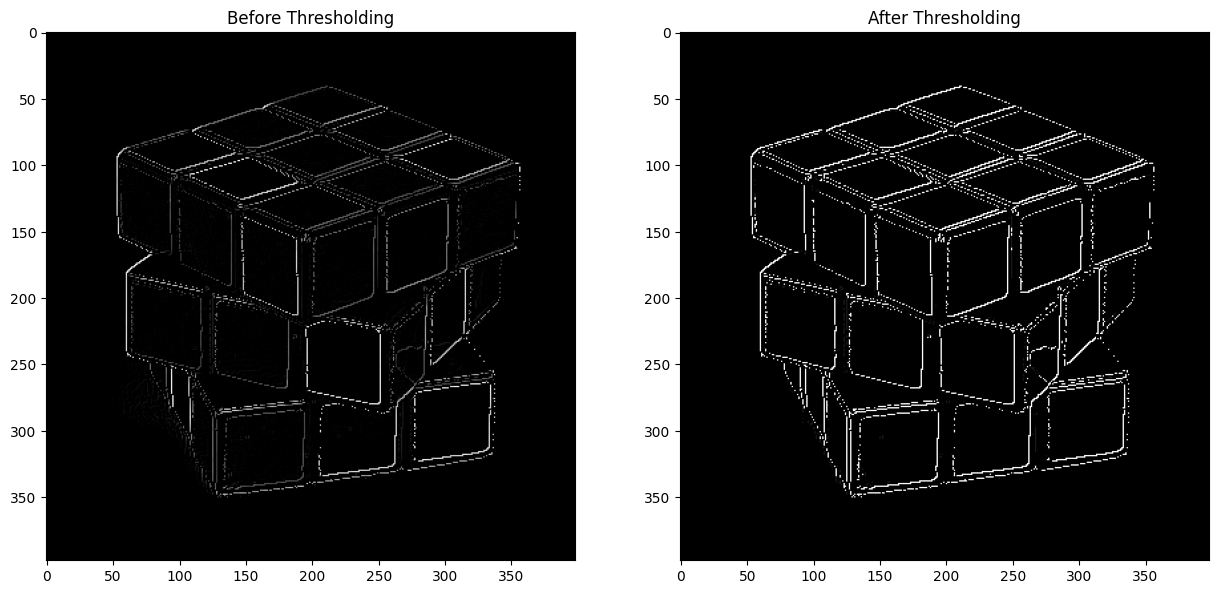

In [17]:
res, weak, strong = threshold(G_NMS, 0.5, 0.2)

fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(G_NMS, 'gray'), plt.title('Before Thresholding')
plt.subplot(122), plt.imshow(res, 'gray'), plt.title('After Thresholding')
plt.show()

### 5. Hysteresis Thresholding to **find the relevant weak edges** *(1 point)*
- Weak edges can be caused by noise or could be relevant,
    - *Connected to strong edges -> true edge*
    - *Not connected to strong edges -> caused by noise*

```
For each pixel:
Compare the magnitude of the pixel being processed with its eight surrounding pixels
    If at least one of these pixels belongs to the strong edges group:
        pixel value == strong (255) 
    else:
        pixel value == 0
```

In [18]:
# Hysterisis pass
def hysteresis(img, weak, strongVal):
    ''' 
    Filter the strong and relevant edges from the gradient magnitude 
    and removes weak edges based on a high and low threshold value

    Parameters
    ----------
    img: np.ndarray
        The gradient magnitude after double thresholding

    weak: int
        The value of the weak edges

    strong: int
        The value of the strong edges

    Returns
    -------
    np.ndarray
        The final image with only strong edges preserved
    '''

    # TODO: YOUR CODE HERE
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                if ((img[i+1, j-1] == strongVal) or (img[i+1, j] == strongVal) or (img[i+1, j+1] == strongVal) or (img[i, j-1] == strongVal) or (img[i, j+1] == strongVal) or (img[i-1, j-1] == strongVal) or (img[i-1, j] == strongVal) or (img[i-1, j+1] == strongVal)):
                    img[i, j] = strongVal
                else:
                    img[i, j] = 0
    return img



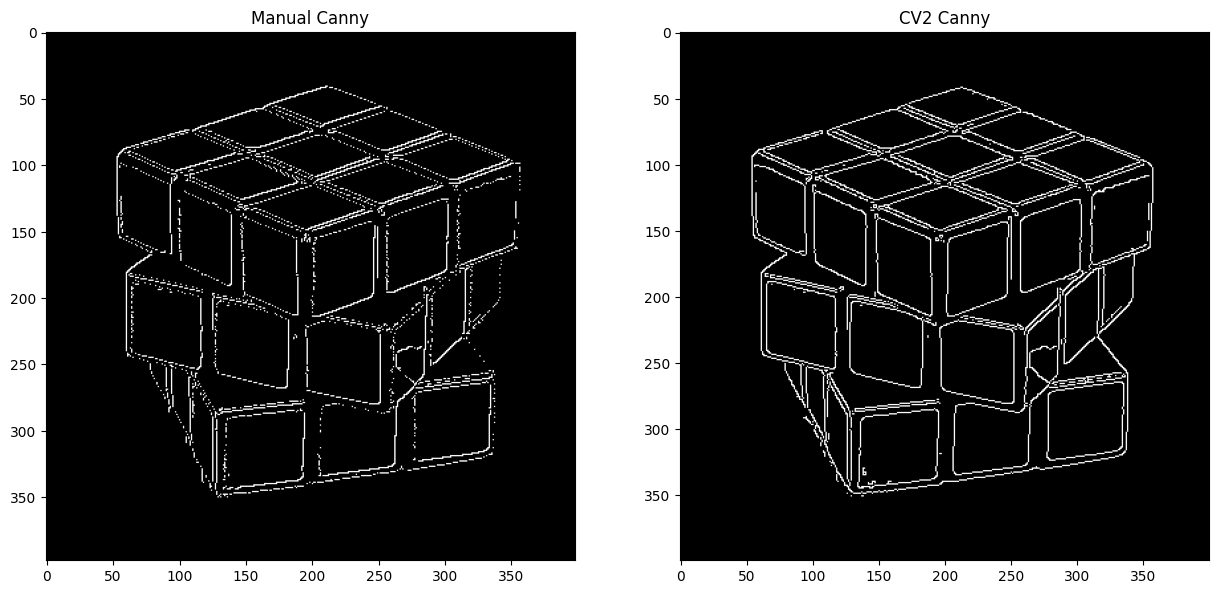

In [19]:
canny_manual = hysteresis(res, weak, strong)

# Usind the CV2 module
canny_cv = cv2.Canny(im, 100, 200)

fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(canny_manual, 'gray'), plt.title('Manual Canny')
plt.subplot(122), plt.imshow(canny_cv, 'gray'), plt.title('CV2 Canny')
plt.show()

## Laplacian filter

- Very sensitive to noise; countered by applying gaussian blur/smoothing to reduce the high frequency noise components
- Pair of Laplacian over Gaussian filter (LoG)

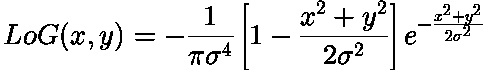

### Creating the **LoG mask** *(1 point)*

In [20]:
def create_LoG(sigma, size):
    '''
    Finds the inflection point (zero crossing point) by checking the neighborhood
    of each pixel and verifying if the sign changes compared to the pixel being processed

    Parameters
    ----------
    sigma: float
        The scale of the filter 

    size: int
        The size of the LoG filter to be applied

    Returns
    -------
    np.ndarray
        The LoG mask to be convolved over the image
    '''

    # TODO: YOUR CODE HERE
   
    x, y = np.meshgrid(np.arange(-size//2 + 1, size//2 + 1), np.arange(-size//2 + 1, size//2 + 1))
    
    LoG = -(1/(np.pi*sigma**4)) * (1 - (x**2 + y**2)/(2*sigma**2)) * np.exp(-(x**2 + y**2)/(2*sigma**2))
    LoG = LoG - np.mean(LoG)

    return LoG



In [21]:
# Create the LoG_mask
LoG_mask = create_LoG(1.4, 7)

# convolving with the LoG mask
LoG_image = convolve(image_array, LoG_mask)

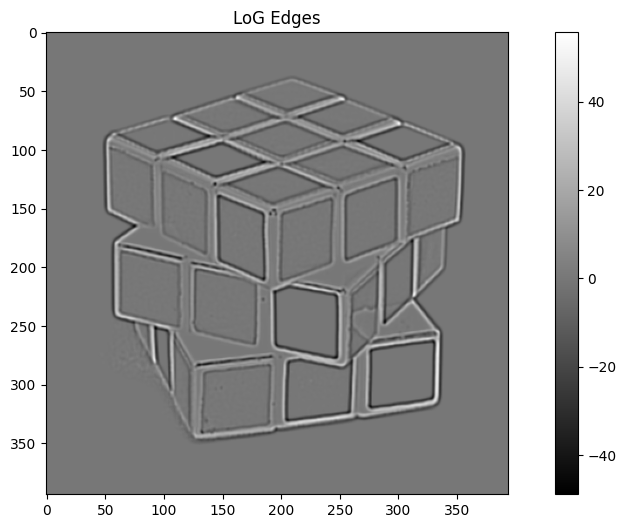

In [22]:
fsize = (12,6)
plt.figure(figsize = fsize)
plt.imshow(LoG_image, 'gray'), plt.title('LoG Edges')
plt.colorbar()
plt.show()

# my zero crossing output was horrible so I gaussian blurred the log image before doing anything to reduce noise

### Estimating edges based on the **zero-crossing** mechanism *(1 point)*

In [23]:
def zero_cross(LoG_image):
    '''
    Finds the inflection point (zero crossing point) by checking the neighborhood
    of each pixel and verifying if the sign changes compared to the pixel being processed

    Parameters
    ----------
    LoG_image: np.ndarray
        The image convolved with the LoG filter

    Returns
    -------
    np.ndarray
        The image with zero crossing edges
    '''
    
  
    LoG_image = cv2.GaussianBlur(LoG_image, (3, 3), 1)
    sign = np.sign(LoG_image)

    sum_neighbors = np.abs(convolve(sign, np.ones((8,8))))

    zero_crossing = np.zeros(LoG_image.shape)
    zero_crossing[np.where(sum_neighbors < 4)] = 255
  
    return zero_crossing




In [24]:
# Find the zero crossings
laplacian_manual = zero_cross(LoG_image)

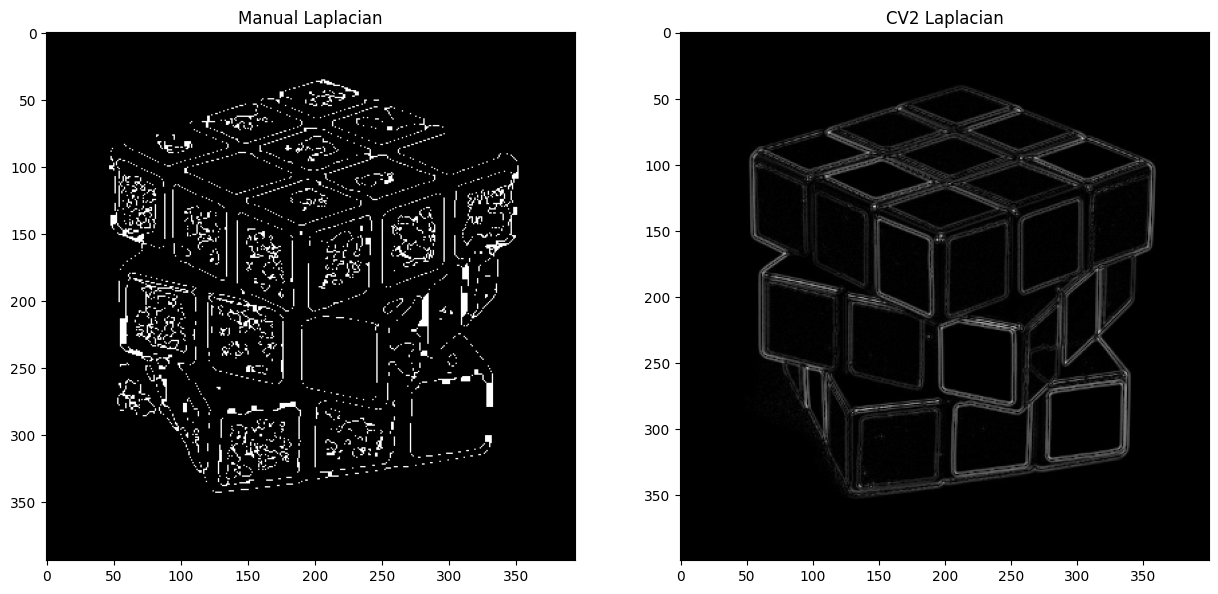

In [25]:
blur_img = cv2.GaussianBlur(image_array, (3, 3), 0)
laplacian = cv2.Laplacian(blur_img, cv2.CV_64F)
laplacian_cv = np.sqrt(laplacian**2)

fsize = (15,8)
plt.figure(figsize = fsize)
plt.subplot(121), plt.imshow(laplacian_manual, cmap='gray'), plt.title('Manual Laplacian')
plt.subplot(122), plt.imshow(laplacian_cv, cmap='gray'), plt.title('CV2 Laplacian')
plt.show()

**Try the convolve function with your own filter** *(1 points)*

Create your own filter (or use one from Google) and convolve it over your imported image

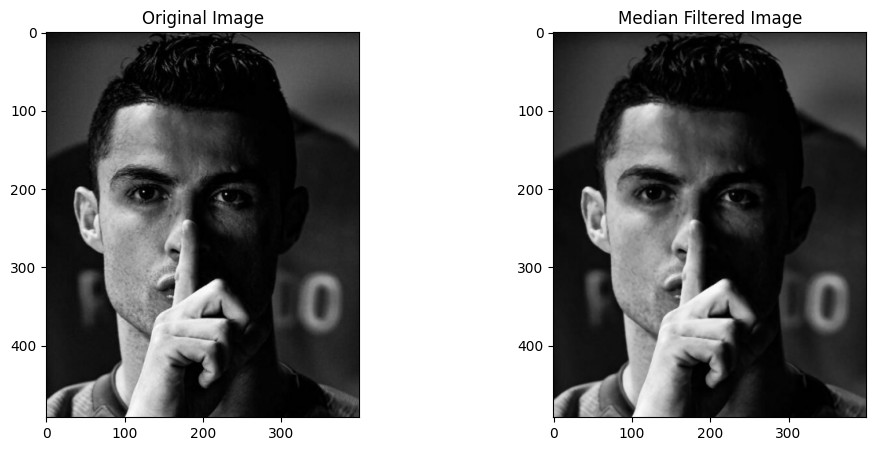

In [33]:
# TODO:
# YOUR FILTER HERE
import cv2
import matplotlib.pyplot as plt

def median_filter(image_path):

    img = cv2.imread(image_path)
    filtered_img = cv2.medianBlur(img, 3)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[1].imshow(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Median Filtered Image')
    plt.show()

median_filter("whatsapp-image-2021-09-17-at-19-07-29-614487da06310e63f57b7235.jpeg")

### you can see a small change

## where would it be preferred to use the laplacian method over canny and vice-versa?

#### If the image has well-defined edges with high contrast, the Canny edge detection method may be preferred. If the image has low contrast or contains blurry edges, the Laplacian method may be more suitable

#### The Laplacian method is a second-order derivative method that is more sensitive to edges with higher frequency components. This method is particularly useful for detecting edges that are not well-defined, such as edges in blurry or noisy images.

#### The Laplacian method is a second-order derivative method that is more sensitive to edges with higher frequency components. This method is particularly useful for detecting edges that are not well-defined, such as edges in blurry or noisy images.